In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
import json

from mmdet.utils import replace_cfg_vals, update_data_root
from confusion_matrix_trash import calculate_confusion_matrix, plot_confusion_matrix

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')

root='/data/ephemeral/home/dataset/'

epoch = 'latest'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'val_split_random.json'
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize
cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.seed=2024
cfg.gpu_ids = [1]
cfg.work_dir = './work_dirs/faster_rcnn_r50_fpn_1x_trash' # 평가 모델 위치

cfg.model.roi_head.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [3]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [4]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

load checkpoint from local path: /data/ephemeral/home/ys/work_dirs/deformable_detr_twostage_refine_r50_16x2_12e_query40_trash/epoch_12.pth


In [5]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[                                 ] 4/977, 2.0 task/s, elapsed: 2s, ETA:   492s

/data/ephemeral/home/baseline/mmdetection/mmdet/models/utils/positional_encoding.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature**(2 * (dim_t // 2) / self.num_feats)
/opt/conda/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/ephemeral/home/baseline/mmdetection/mmdet/models/utils/transformer.py:883: UserWarning: __floordiv__ is deprecated, and its behavior will change in a fut

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 977/977, 12.3 task/s, elapsed: 80s, ETA:     0s

In [55]:
# Streamlit 시각화에 사용할 json 파일 출력
results = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    img_id = img_ids[i]
    image_info = coco.loadImgs(coco.getImgIds(imgIds=img_id))[0]
    for j in range(class_num):
        for o in out[j]:
            
            result_dict = {
                "image_id": image_info['id'],
                "category_id": j,
                "bbox": [float(o[0]), float(o[1]), float(o[2]), float(o[3])],
                "score": float(o[4])
            }
            results.append(result_dict)

# json 파일
json_file = os.path.join(cfg.work_dir, 'val_prediction' + f'_{epoch}.json')
with open(json_file, 'w') as f:
    json.dump(results, f)

loading annotations into memory...


Done (t=0.02s)
creating index...
index created!


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 977/977, 509.1 task/s, elapsed: 2s, ETA:     0s

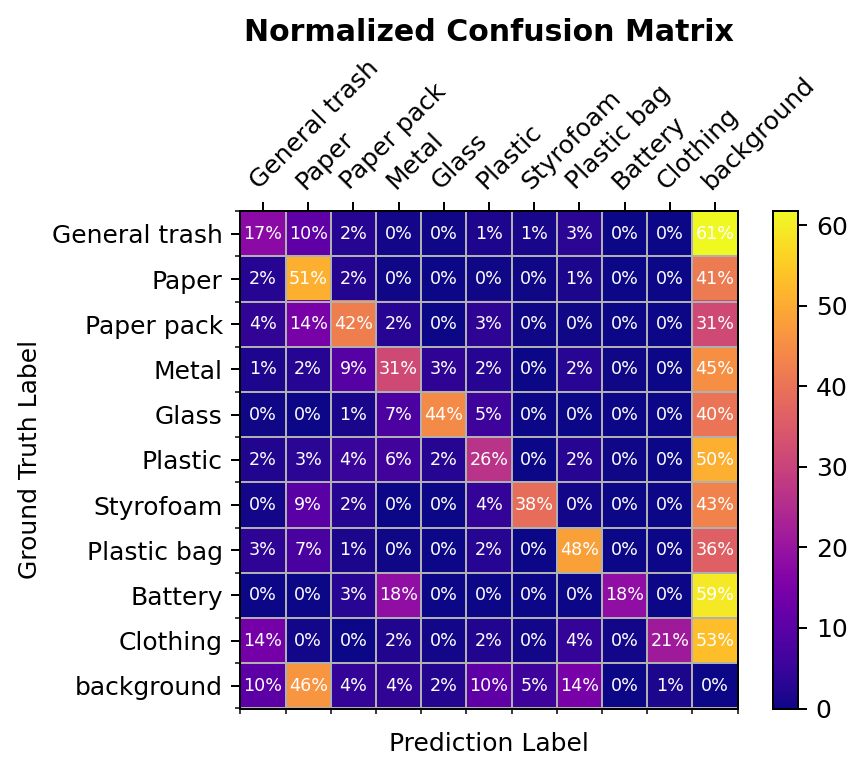

In [6]:
# Confusion matrix 출력

# pkl 파일 생성
pkl_path = cfg.work_dir + "/result.pkl"
mmcv.dump(output, pkl_path)

# replace the ${key} with the value of cfg.key
cfg = replace_cfg_vals(cfg)

# update data root according to MMDET_DATASETS
update_data_root(cfg)

results = mmcv.load(pkl_path)
assert isinstance(results, list)
if isinstance(results[0], list):
    pass
elif isinstance(results[0], tuple):
    results = [result[0] for result in results]
else:
    raise TypeError('invalid type of prediction results')

if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
dataset = build_dataset(cfg.data.test)

# score_thr : confidence score가 score_thr 이하인 경우 배경 클래스로 예측한 것으로 봄(mmdetection tools의 default: 0.3)
confusion_matrix = calculate_confusion_matrix(dataset, results, score_thr=0.3)

plot_confusion_matrix(
    confusion_matrix,
    dataset.CLASSES + ('background', ),
    save_dir=cfg.work_dir)